In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
dropout_value = 0.05

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size, stride, padding, groups=in_channels
        )
        self.pointwise = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Dropout(dropout_value)
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            # output_size = 32 , receptive_field = 3

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            # output_size = 32 , receptive_field = 5

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            # output_size = 16 , receptive_field = 7

            DepthwiseSeparableConv(in_channels=64, out_channels=128)
            # output_size = 16 , receptive_field = 11
        )

        # TRANSITION BLOCK 1
        self.transition1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16 , receptive_field = 11

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            # output_size = 16 , receptive_field = 15

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            # output_size = 16 , receptive_field = 21

            DepthwiseSeparableConv(in_channels=64, out_channels=128)
            # output_size = 16 , receptive_field = 25
        )

        # TRANSITION BLOCK 2
        self.transition2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16 , receptive_field = 25

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            # output_size = 16 , receptive_field = 29

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            # output_size = 16 , receptive_field = 33

            DepthwiseSeparableConv(in_channels=64, out_channels=128)
            # output_size = 16 , receptive_field = 37
        )
            
        # TRANSITION BLOCK 3
        self.transition3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16 , receptive_field = 37

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            # output_size = 16 , receptive_field = 41

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), dilation=2, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            # output_size = 14 , receptive_field = 49

            DepthwiseSeparableConv(in_channels=64, out_channels=128)
            # output_size = 14 , receptive_field = 57
        )

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=14)
        ) # output_size = 1

        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.transition1(x)
        x = self.convblock2(x)
        x = self.transition2(x)
        x = self.convblock3(x)
        x = self.transition3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)  # Flatten after GAP
        x = self.fc(x)

        return x

In [4]:
!pip install torchsummary

In [26]:
from __future__ import print_function
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# CIFAR-10 Mean and Std (calculated over the entire dataset)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

# Albumentations Transformations
class AlbumentationsTransform:
    def __init__(self, mean, std):
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),  # Random horizontal flip
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),  # Shift, Scale, Rotate
            A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, 
                            fill_value=(np.array(mean) * 255).tolist(), mask_fill_value=None, p=0.5),  # CoarseDropout
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0),  # Normalize
            ToTensorV2(),  # Convert to tensor
        ])
    
    def __call__(self, img):
        # Albumentations expects the image in OpenCV format (HWC, uint8)
        image = np.array(img)  # Convert PIL image to numpy array
        return self.transform(image=image)["image"]

# Apply Albumentations Transformations to CIFAR-10
train = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=AlbumentationsTransform(mean=CIFAR10_MEAN, std=CIFAR10_STD)
)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD)
])

test = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  Net().to(device)

def train(model, device, train_loader, optimizer,scheduler, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 16, 16]          18,432
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
          Dropout-12           [-1, 64, 16, 16]               0
 

Finding optimal LR...
Number of steps: 391


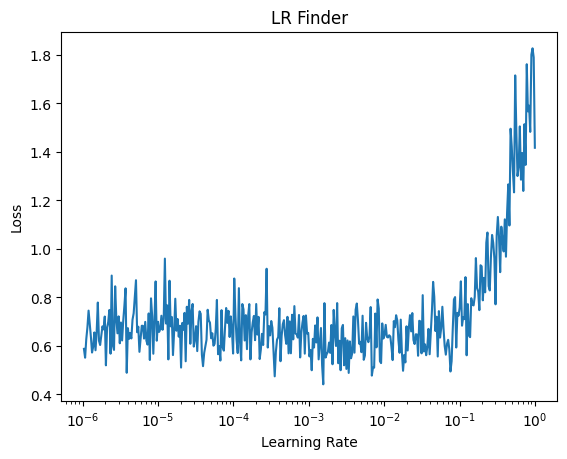

Optimal LR: 0.0015553060335606536


In [37]:
# LR Finder
def find_lr(model, train_loader, criterion, optimizer, device):
    model.train()
    lrs = []
    losses = []
    
    min_lr = 1e-6
    max_lr = 1
    num_steps = len(train_loader)
    print(f"Number of steps: {num_steps}")
    
    # Corrected lambda function for learning rate scaling
    lr_lambda = lambda x: min_lr * (max_lr / min_lr) ** (x / num_steps)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    for i, (inputs, labels) in enumerate(train_loader):
        if i >= num_steps:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        lrs.append(scheduler.get_last_lr()[0])
        losses.append(loss.item())

    # Plot the learning rate vs. loss
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('LR Finder')
    plt.show()

    return lrs, losses

optimizer = optim.SGD(model.parameters(), lr=1, momentum=0.9)
criterion = nn.CrossEntropyLoss()
print("Finding optimal LR...")
lrs, losses = find_lr(model, train_loader, criterion, optimizer, device)
best_lr = lrs[losses.index(min(losses))]
print(f"Optimal LR: {best_lr}")

In [38]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 50
best_lr = 0.0004
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.1,  # max_lr provided to OneCycleLR
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    div_factor=(0.1/best_lr),   # Determines starting LR
    final_div_factor=1e4
)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer,scheduler, epoch)
    test(model, device, test_loader)
    print(f"Learning Rate = {optimizer.param_groups[0]['lr']}\n")
    if (test_acc[-1] > 86):
      break

EPOCH: 0


Loss=1.2657976150512695 Batch_id=390 Accuracy=46.14: 100%|██████████| 391/391 [00:14<00:00, 27.69it/s]



Test set: Average loss: 0.0090, Accuracy: 5948/10000 (59.48%)

Learning Rate = 0.0014886193196333164

EPOCH: 1


Loss=1.1480542421340942 Batch_id=390 Accuracy=56.21: 100%|██████████| 391/391 [00:13<00:00, 28.17it/s]



Test set: Average loss: 0.0073, Accuracy: 6759/10000 (67.59%)

Learning Rate = 0.004706883221381464

EPOCH: 2


Loss=0.951001763343811 Batch_id=390 Accuracy=63.28: 100%|██████████| 391/391 [00:13<00:00, 28.17it/s] 



Test set: Average loss: 0.0062, Accuracy: 7256/10000 (72.56%)

Learning Rate = 0.009914090329376166

EPOCH: 3


Loss=0.6593869924545288 Batch_id=390 Accuracy=67.61: 100%|██████████| 391/391 [00:13<00:00, 29.16it/s]



Test set: Average loss: 0.0055, Accuracy: 7590/10000 (75.90%)

Learning Rate = 0.016882583364135645

EPOCH: 4


Loss=0.8982514142990112 Batch_id=390 Accuracy=70.55: 100%|██████████| 391/391 [00:13<00:00, 28.34it/s]



Test set: Average loss: 0.0050, Accuracy: 7784/10000 (77.84%)

Learning Rate = 0.025307702239460356

EPOCH: 5


Loss=0.7168463468551636 Batch_id=390 Accuracy=72.41: 100%|██████████| 391/391 [00:13<00:00, 29.03it/s]



Test set: Average loss: 0.0047, Accuracy: 7921/10000 (79.21%)

Learning Rate = 0.03482110369519424

EPOCH: 6


Loss=0.6430627107620239 Batch_id=390 Accuracy=73.65: 100%|██████████| 391/391 [00:13<00:00, 28.66it/s]



Test set: Average loss: 0.0045, Accuracy: 7976/10000 (79.76%)

Learning Rate = 0.04500686513615098

EPOCH: 7


Loss=0.6695082187652588 Batch_id=390 Accuracy=74.63: 100%|██████████| 391/391 [00:13<00:00, 29.03it/s]



Test set: Average loss: 0.0044, Accuracy: 8069/10000 (80.69%)

Learning Rate = 0.055419668622981096

EPOCH: 8


Loss=0.5341129899024963 Batch_id=390 Accuracy=75.26: 100%|██████████| 391/391 [00:13<00:00, 29.04it/s] 



Test set: Average loss: 0.0043, Accuracy: 8151/10000 (81.51%)

Learning Rate = 0.06560427001723848

EPOCH: 9


Loss=0.6539150476455688 Batch_id=390 Accuracy=75.32: 100%|██████████| 391/391 [00:13<00:00, 28.86it/s]



Test set: Average loss: 0.0042, Accuracy: 8187/10000 (81.87%)

Learning Rate = 0.07511540209641096

EPOCH: 10


Loss=0.7809025049209595 Batch_id=390 Accuracy=75.82: 100%|██████████| 391/391 [00:13<00:00, 29.16it/s] 



Test set: Average loss: 0.0044, Accuracy: 8091/10000 (80.91%)

Learning Rate = 0.08353724148166439

EPOCH: 11


Loss=0.6546652913093567 Batch_id=390 Accuracy=75.94: 100%|██████████| 391/391 [00:13<00:00, 28.62it/s] 



Test set: Average loss: 0.0042, Accuracy: 8201/10000 (82.01%)

Learning Rate = 0.0905015882910053

EPOCH: 12


Loss=0.6415401101112366 Batch_id=390 Accuracy=76.40: 100%|██████████| 391/391 [00:13<00:00, 29.19it/s] 



Test set: Average loss: 0.0040, Accuracy: 8259/10000 (82.59%)

Learning Rate = 0.09570396370976406

EPOCH: 13


Loss=0.6079355478286743 Batch_id=390 Accuracy=76.48: 100%|██████████| 391/391 [00:13<00:00, 28.12it/s] 



Test set: Average loss: 0.0040, Accuracy: 8275/10000 (82.75%)

Learning Rate = 0.09891692169822795

EPOCH: 14


Loss=0.60579514503479 Batch_id=390 Accuracy=76.94: 100%|██████████| 391/391 [00:13<00:00, 29.11it/s]   



Test set: Average loss: 0.0042, Accuracy: 8214/10000 (82.14%)

Learning Rate = 0.09999999868250198

EPOCH: 15


Loss=0.7893738746643066 Batch_id=390 Accuracy=76.78: 100%|██████████| 391/391 [00:13<00:00, 28.34it/s] 



Test set: Average loss: 0.0040, Accuracy: 8260/10000 (82.60%)

Learning Rate = 0.09979768456753677

EPOCH: 16


Loss=0.6312569379806519 Batch_id=390 Accuracy=77.43: 100%|██████████| 391/391 [00:13<00:00, 28.99it/s] 



Test set: Average loss: 0.0039, Accuracy: 8342/10000 (83.42%)

Learning Rate = 0.09919442893802632

EPOCH: 17


Loss=0.5336273908615112 Batch_id=390 Accuracy=77.27: 100%|██████████| 391/391 [00:13<00:00, 28.37it/s] 



Test set: Average loss: 0.0039, Accuracy: 8300/10000 (83.00%)

Learning Rate = 0.09819508885359095

EPOCH: 18


Loss=0.676188588142395 Batch_id=390 Accuracy=77.64: 100%|██████████| 391/391 [00:13<00:00, 29.07it/s]  



Test set: Average loss: 0.0038, Accuracy: 8328/10000 (83.28%)

Learning Rate = 0.09680771041298804

EPOCH: 19


Loss=0.6817806959152222 Batch_id=390 Accuracy=78.07: 100%|██████████| 391/391 [00:13<00:00, 28.34it/s] 



Test set: Average loss: 0.0038, Accuracy: 8316/10000 (83.16%)

Learning Rate = 0.09504346397165599

EPOCH: 20


Loss=0.7169158458709717 Batch_id=390 Accuracy=78.01: 100%|██████████| 391/391 [00:13<00:00, 28.98it/s] 



Test set: Average loss: 0.0039, Accuracy: 8318/10000 (83.18%)

Learning Rate = 0.09291655420458032

EPOCH: 21


Loss=0.44891053438186646 Batch_id=390 Accuracy=78.09: 100%|██████████| 391/391 [00:13<00:00, 28.29it/s]



Test set: Average loss: 0.0037, Accuracy: 8440/10000 (84.40%)

Learning Rate = 0.09044410573860286

EPOCH: 22


Loss=0.7088714838027954 Batch_id=390 Accuracy=78.77: 100%|██████████| 391/391 [00:13<00:00, 29.12it/s] 



Test set: Average loss: 0.0036, Accuracy: 8439/10000 (84.39%)

Learning Rate = 0.08764602527499546

EPOCH: 23


Loss=0.6085449457168579 Batch_id=390 Accuracy=78.49: 100%|██████████| 391/391 [00:13<00:00, 28.47it/s] 



Test set: Average loss: 0.0037, Accuracy: 8406/10000 (84.06%)

Learning Rate = 0.08454484131240643

EPOCH: 24


Loss=0.8219462633132935 Batch_id=390 Accuracy=78.97: 100%|██████████| 391/391 [00:13<00:00, 29.06it/s] 



Test set: Average loss: 0.0037, Accuracy: 8404/10000 (84.04%)

Learning Rate = 0.08116552276063592

EPOCH: 25


Loss=0.5546939373016357 Batch_id=390 Accuracy=79.31: 100%|██████████| 391/391 [00:13<00:00, 28.95it/s] 



Test set: Average loss: 0.0036, Accuracy: 8453/10000 (84.53%)

Learning Rate = 0.07753527790565562

EPOCH: 26


Loss=0.6168568134307861 Batch_id=390 Accuracy=79.07: 100%|██████████| 391/391 [00:13<00:00, 29.14it/s] 



Test set: Average loss: 0.0036, Accuracy: 8489/10000 (84.89%)

Learning Rate = 0.07368333534448844

EPOCH: 27


Loss=0.6174392104148865 Batch_id=390 Accuracy=79.57: 100%|██████████| 391/391 [00:13<00:00, 29.00it/s] 



Test set: Average loss: 0.0036, Accuracy: 8491/10000 (84.91%)

Learning Rate = 0.06964070865373136

EPOCH: 28


Loss=0.6464061141014099 Batch_id=390 Accuracy=79.67: 100%|██████████| 391/391 [00:13<00:00, 28.37it/s] 



Test set: Average loss: 0.0035, Accuracy: 8509/10000 (85.09%)

Learning Rate = 0.06543994668647235

EPOCH: 29


Loss=0.39973360300064087 Batch_id=390 Accuracy=79.98: 100%|██████████| 391/391 [00:13<00:00, 28.90it/s]



Test set: Average loss: 0.0034, Accuracy: 8503/10000 (85.03%)

Learning Rate = 0.06111487150806372

EPOCH: 30


Loss=0.5025667548179626 Batch_id=390 Accuracy=79.98: 100%|██████████| 391/391 [00:13<00:00, 28.35it/s] 



Test set: Average loss: 0.0034, Accuracy: 8545/10000 (85.45%)

Learning Rate = 0.05670030608073902

EPOCH: 31


Loss=0.4676051139831543 Batch_id=390 Accuracy=80.23: 100%|██████████| 391/391 [00:13<00:00, 28.99it/s] 



Test set: Average loss: 0.0035, Accuracy: 8496/10000 (84.96%)

Learning Rate = 0.052231793889596624

EPOCH: 32


Loss=0.6628190279006958 Batch_id=390 Accuracy=80.27: 100%|██████████| 391/391 [00:13<00:00, 28.28it/s] 



Test set: Average loss: 0.0034, Accuracy: 8528/10000 (85.28%)

Learning Rate = 0.04774531276735699

EPOCH: 33


Loss=0.7213866710662842 Batch_id=390 Accuracy=80.56: 100%|██████████| 391/391 [00:13<00:00, 29.02it/s] 



Test set: Average loss: 0.0035, Accuracy: 8509/10000 (85.09%)

Learning Rate = 0.04327698522200825

EPOCH: 34


Loss=0.43299517035484314 Batch_id=390 Accuracy=80.97: 100%|██████████| 391/391 [00:13<00:00, 28.19it/s]



Test set: Average loss: 0.0033, Accuracy: 8567/10000 (85.67%)

Learning Rate = 0.03886278759961143

EPOCH: 35


Loss=0.4668017029762268 Batch_id=390 Accuracy=81.07: 100%|██████████| 391/391 [00:13<00:00, 29.06it/s] 



Test set: Average loss: 0.0034, Accuracy: 8521/10000 (85.21%)

Learning Rate = 0.03453826042391593

EPOCH: 36


Loss=0.4164941906929016 Batch_id=390 Accuracy=81.40: 100%|██████████| 391/391 [00:13<00:00, 28.37it/s] 



Test set: Average loss: 0.0033, Accuracy: 8627/10000 (86.27%)

Learning Rate = 0.030338222244959676

